<a href="https://colab.research.google.com/github/lmassaron/fine-tuning-workshop/blob/main/sherlock_knowledge_sft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check the GPU information
!nvidia-smi

Tue Sep 23 21:23:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install necessary libraries for model training and evaluation
%%capture
!uv pip install -U transformers trl peft accelerate bitsandbytes numpy==1.26.4 scipy==1.12.0

In [3]:
# Import and print the versions of the installed libraries
import torch
import trl
import peft
import bitsandbytes

print(f"Using PyTorch version: {torch.__version__}")
print(f"Using TRL version: {trl.__version__}")
print(f"Using peft version: {peft.__version__}")
print(f"Using bitsandbytes version: {bitsandbytes.__version__}")

Using PyTorch version: 2.8.0+cu126
Using TRL version: 0.23.0
Using peft version: 0.17.1
Using bitsandbytes version: 0.47.0


In [4]:
# Import various libraries needed for data handling, model loading, and training
import os
import gc
import warnings
import torch
import numpy as np
import pandas as pd
import torch
import subprocess
import sys
import random
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from huggingface_hub import login
from peft import LoraConfig
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import set_seed
from trl import GRPOConfig, GRPOTrainer, SFTConfig, SFTTrainer

In [ ]:
DEMO = False

In [24]:
# Define configuration parameters for the model and data
class Config:
    """Configuration parameters"""

    SIZE = "3-1b"
    MODEL_NAME = f"google/gemma-{SIZE}-it"
    OUTPUT_MODEL = f"gemma-{SIZE}-sherlock-expert"

    max_seq_length = 2048
    seed = 0

In [6]:
# Initialization script to set up the environment and Hugging Face login
def init():
    """Initialization script"""
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

    # It is recommended to set the HF_TOKEN as an environment variable
    token = os.environ.get("HF_TOKEN")
    if token:
        login(token=token)
    else:
      try:
        from google.colab import userdata
        # Retrieve your Hugging Face token from Colab's secrets manager
        # The name 'HF_TOKEN' should match the name you used in the secrets tab
        hf_token = userdata.get('HF_TOKEN')

        # Check if the token was successfully retrieved
        if hf_token:
            # Log in to Hugging Face using the retrieved token
            # The `add_to_git_credential=True` argument is optional and useful if you plan to push models to the Hub
            login(token=hf_token, add_to_git_credential=True)
            print("Hugging Face login successful using Google Colab secrets!")
        else:
            print("Error: HF_TOKEN not found in Google Colab secrets or is empty.")
            print("Please ensure you have created a secret named 'HF_TOKEN' in the 'Secrets' tab (🔑) on the left sidebar.")
      except:
        print("HF_TOKEN not set. You might need to log in manually.")

    torch.cuda.empty_cache()
    gc.collect()
    warnings.filterwarnings("ignore")

def is_bfloat16_supported():
    """Checks if the current device supports bfloat16."""
    return torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8


def info_device():
    """Get device for PyTorch"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

def cleanup(objects=None):
    """Cleans the memory"""
    if objects is not None:
        for obj in objects:
            del obj
    torch.cuda.empty_cache()
    gc.collect()

def set_deterministic(seed):
  """Sets all seeds and CUDA settings for deterministic results."""
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU. [2, 3]
  set_seed(seed)

In [7]:
def install_flash_attn_conditionally():
    """
    Checks the GPU's compute capability and installs the appropriate version of flash-attn.
    """
    if not torch.cuda.is_available():
        print("No CUDA-enabled GPU found. Skipping flash-attn installation.")
        return

    try:
        # Get the compute capability of the first available GPU
        major, minor = torch.cuda.get_device_capability(0)
        compute_capability = float(f"{major}.{minor}")
        gpu_name = torch.cuda.get_device_name(0)
        print(f"Found GPU: {gpu_name} with Compute Capability: {compute_capability}")

        # Check for Ampere, Ada, Hopper, or newer architectures (for FlashAttention 2)
        if compute_capability >= 8.0:
            # Ampere, Ada, and Hopper architectures support bfloat16 and are ideal for FlashAttention 2
            is_bf16_supported = torch.cuda.is_bf16_supported()
            if is_bf16_supported:
                print("GPU supports BF16 and is compatible with FlashAttention 2.")
                print("Proceeding with installation of the latest 'flash-attn'...")
                # Install the latest version of flash-attn
                install_package("flash-attn", "-q --no-build-isolation")
                return True
            else:
                 print("GPU architecture is compatible, but BF16 is not supported. Skipping installation.")
                 return False
        # Check for Turing architecture (for original FlashAttention)
        elif compute_capability == 7.5:
            print("Turing architecture GPU detected. Compatible with original FlashAttention (v1.x).")
            print("Proceeding with installation of 'flash-attn==1.0.9'...")
            # Install a specific version of flash-attn compatible with Turing
            install_package("flash-attn==1.0.9", "-q --no-build-isolation")
            return True

        else:
            print(f"GPU with compute capability {compute_capability} is not supported by flash-attn. Skipping installation.")
            return False
    except Exception as e:
        print(f"An error occurred during GPU check or installation: {e}")
        return False

def install_package(package_name, *pip_args):
    """
    A helper function to install a pip package using subprocess.
    """
    try:
        command = [sys.executable, "-m", "uv", "pip", "install", package_name]
        command.extend(pip_args)
        subprocess.check_call(command)
        print(f"Successfully installed {package_name}.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package_name}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [8]:
# Initialize the environment, get parameters, device, and data type
init()
params = Config()
device = info_device()
dtype = torch.bfloat16 if is_bfloat16_supported() else torch.float16
print(f"Using dtype: {dtype}")
is_flash_attn_available = False #install_flash_attn_conditionally()
set_deterministic(params.seed)

Hugging Face login successful using Google Colab secrets!
Using device: cuda
Using dtype: torch.float16


In [9]:
# Function to load dataset from Hugging Face Hub
def get_data(repo_id, mapping_func=None, split="train"):
    """Upload HF dataset"""
    data = load_dataset(repo_id, cache_dir="/tmp")[split]
    if mapping_func:
      data = data.map(mapping_func)
    return data

In [10]:
# Load the Sherlock QA dataset
data = get_data(repo_id="lmassaron/Sherlock_QA")

In [11]:
data

Dataset({
    features: ['messages'],
    num_rows: 44294
})

In [12]:
# Deterministically sample k rows by setting a random_state
if DEMO:
    k = 1_000
else:
  k = 44_294
eval_proportion = 0.2
eval_size = int(k * eval_proportion)
train_size = k - eval_size

# Shuffle the dataset with a fixed seed for reproducibility
shuffled_data = data.shuffle(seed=42)

# Select the first k elements to create your sample
sampled_data = shuffled_data.select(range(k))

# Split the sampled data into training and test sets
train_data = sampled_data.select(range(train_size))
eval_data = sampled_data.select(range(train_size, k))

In [13]:
def remove_system_prompt(example):
    if example['messages'][0]['role'] == 'system':
        # Return all messages except the first one
        return {"messages": example['messages'][1:]}
    return example

train_data = train_data.map(remove_system_prompt)
eval_data = eval_data.map(remove_system_prompt)

In [14]:
attn_implementation = "flash_attention_2" if is_flash_attn_available else "eager"

model = AutoModelForCausalLM.from_pretrained(
    params.MODEL_NAME,
    dtype=dtype,
    device_map=device,
    attn_implementation=attn_implementation
)

tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME, max_seq_length=params.max_seq_length)

# Explicitly enable use_cache for faster inference
model.config.use_cache = True

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [15]:
print(f"Model: {model.name_or_path}")
print(f"Device: {model.device}")
print(f"DType: {model.dtype}")
print(f"Attention Implementation: {attn_implementation}")

Model: google/gemma-3-1b-it
Device: cuda:0
DType: torch.float16
Attention Implementation: eager


In [20]:
# LoRA configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

# SFT (Supervised Fine-tuning) configuration
training_arguments = SFTConfig(
    output_dir="logs",
    seed=params.seed,
    num_train_epochs=1,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",
    save_steps=0,
    logging_steps=25 if DEMO else 1_000,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=not(is_bfloat16_supported()),
    bf16=is_bfloat16_supported(),
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    eval_strategy='steps',
    eval_steps = 25 if DEMO else 1_000,
    eval_accumulation_steps=1,
    lr_scheduler_type="cosine",
    dataset_text_field="messages",
    packing=False,
    max_length=params.max_seq_length,
    report_to="tensorboard",
)

# Initialize the trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,

)

In [21]:
# Train model
trainer.train()

# Save the fine-tuned LoRA adapter
trainer.model.save_pretrained("trained-model")

Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
25,5.028100,2.704678,2.665623,5673.000000,0.589364
50,2.248700,2.245058,2.188717,11635.000000,0.628357
75,2.116600,2.180986,2.125159,17594.000000,0.634237
100,2.116000,2.173916,2.111056,23302.000000,0.632928


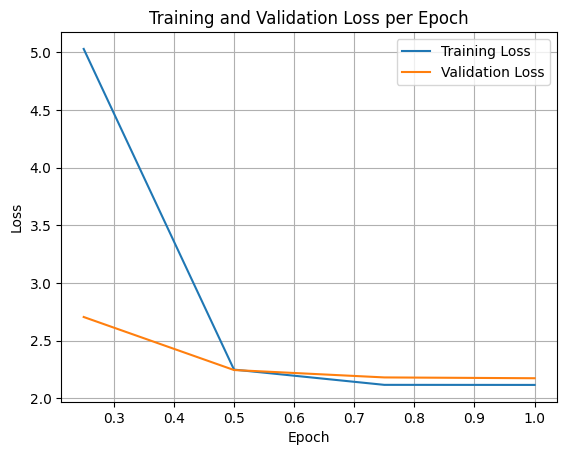

In [22]:
# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
lora_output_dir = f"{params.OUTPUT_MODEL}-lora"
trainer.model.save_pretrained(lora_output_dir)
print(f"LoRA adapters saved to {lora_output_dir}")
# Also save the tokenizer with the LoRA adapters for convenience
tokenizer.save_pretrained(lora_output_dir)

# Define the name for your repository on the Hub
repo_name = "lmassaron/" + lora_output_dir

# Push the model to the Hub
model.push_to_hub(repo_name)

# Push the tokenizer to the Hub
tokenizer.push_to_hub(repo_name)

print(f"Model and tokenizer pushed to {repo_name}")

LoRA adapters saved to gemma-3-1b-sherlock-expert-lora


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rt-lora/model.safetensors:   0%|          |  559kB / 2.21GB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pert-lora/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...xpert-lora/tokenizer.json:  75%|#######5  | 25.2MB / 33.4MB            

Model and tokenizer pushed to lmassaron/gemma-3-1b-sherlock-expert-lora


In [28]:
print("\nMerging the final model")
merged_model = trainer.model.merge_and_unload()

# Save model and tokenizer
output_path = f"{params.OUTPUT_MODEL}"
print(f"Saving the final model to {output_path}")
merged_model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)

# Define the name for your repository on the Hub
repo_name = "lmassaron/" + output_path

# Push the model to the Hub
model.push_to_hub(repo_name)

# Push the tokenizer to the Hub
tokenizer.push_to_hub(repo_name)

print(f"Model and tokenizer pushed to {repo_name}")


Merging the final model
Saving the final model to gemma-3-1b-sherlock-expert


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rt-lora/model.safetensors:   2%|2         | 41.9MB / 2.00GB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pert-lora/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...xpert-lora/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/gemma-3-1b-sherlock-expert-lora
